## Problem Set 01
### AST 8110, Fall 2022
#### Tyler Barna

In [1]:
import time
bigstart = time.time()
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
#import numba

import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random
from tqdm import tqdm
#from numba import jit
from scipy.stats import binned_statistic as binstat

## Set Seed
random.seed(8110)

## debug mode for fast testing
debug = False
filt = 10 ## factor to reduce the size of the data set by


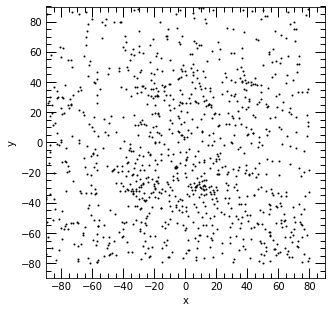

In [2]:
## read in data
data = np.loadtxt('pset1data.txt')
if debug:
    data = data[::filt]

## plot data
def plot_data(dat=data):
    fig, ax = plt.figure(figsize=(5,5)), plt.gca()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major',direction='in',top=True,right=True,length=10,width=1)
    ax.tick_params(axis='both', which='minor',direction='in',top=True,right=True, length=5,width=1)
    
    ax.plot(dat[:,0],dat[:,1],'.',markersize=2,color='black');
    plt.xlim(-90,90);
    plt.ylim(-90,90);
    plt.xlabel('x');
    plt.ylabel('y');
    return fig, ax
    
plot_data(dat=data);

In [3]:
## Generate Random galaxy positions
datSize = len(data)
galMultiplier = 10
def gen_galaxy_positions(N=datSize*galMultiplier,pkl=False,save=False,timeit=True):
    start_time = time.time() if timeit else None
    """
    Generates N random galaxy positions
    """
    if pkl and os.path.isfile(pkl):
        data = pd.read_pickle(pkl)
        return data
    else:
        x = np.random.uniform(-90,80,N)
        y = np.random.uniform(-80,90,N)
        data = np.column_stack((x,y))
        if save:
            pd.to_pickle(data, save)
        print("--- %s seconds ---" % (time.time() - start_time)) if timeit else None
        return data


--- 0.001371145248413086 seconds ---


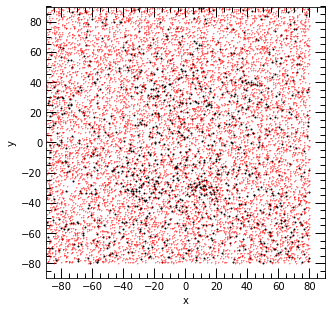

In [4]:
## import random galaxy positions previously generated and plot them
randData = gen_galaxy_positions()
if debug:
    randData = randData[::filt]
fig, ax = plot_data(dat=data);
ax.plot(randData[:,0],randData[:,1],'+',markersize=1,color='red',alpha=0.5);

In [5]:
## calculate distances to other points
def get_dist(mode='dd',data1=None,data2=None,pkl=False,save=False, timeit=True):
    start_time = time.time() if timeit else None
    if pkl and os.path.isfile(pkl):
        dist = pd.read_pickle(pkl)
        return dist
    elif data1 is not None and data2 is not None: ##case where I want to explicitly pass in data
        d1 = data1
        d2 = data2
    elif mode == 'dd':
        d1 = data 
        d2 = data
    elif mode =='rr':
        d1 = randData
        d2 = randData
    elif mode == 'dr':
        d1 = data
        d2 = randData
    
    dist = np.linalg.norm(d2[:,None]-d1,axis=-1) ## calculates distances between all points in d1 and d2 (issue: double counts the distances if in dd or rr. Solved by only taking the upper triangle of the matrix)

    if mode == 'dd' or mode == 'rr': ## only take upper triangle of matrix to prevent double counting
        offset = 1 ## offset to remove self distances in dd and rr (i.e. distance between a point and itself)
        slice_idx = np.triu_indices_from(dist,k=offset) ## get indices for upper triangle of matrix
        #print(slice_idx)
        dist = dist[slice_idx] ## get upper triangle of matrix using indices
    elif mode == 'dr':
        dist = dist.flatten()
    if save:
        pd.to_pickle(dist, save)
    print("--- %s seconds ---" % (time.time() - start_time)) if timeit else None
    return dist

In [6]:
## calculate distances
dd = get_dist('dd')
rr = get_dist('rr')
dr = get_dist('dr')

--- 0.05332517623901367 seconds ---
--- 5.226299524307251 seconds ---
--- 0.3253178596496582 seconds ---


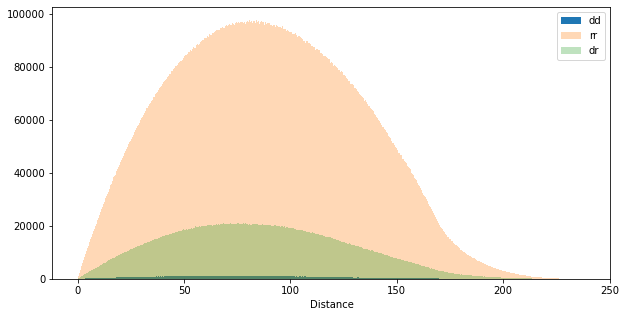

In [7]:
## plot histograms of distances
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.hist(dd,bins=1000,density=False,alpha=1,label='dd');
plt.hist(rr,bins=1000,density=False, alpha=0.3,label='rr');
plt.hist(dr,bins=1000,density=False, alpha=0.3,label='dr');
plt.legend();
plt.xlabel('Distance');
plt.show()
## note here: you need to divide by the number of pairs so that you have the same number of pairs for dd, rr, and dr 

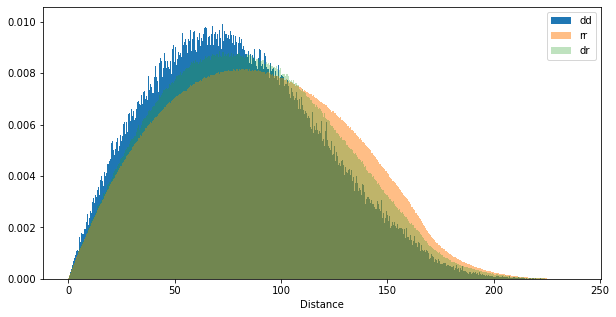

In [8]:
## do another histogram, but normalized
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.hist(dd,bins=1000,density=True,alpha=1,label='dd');
plt.hist(rr,bins=1000,density=True, alpha=0.5,label='rr');
plt.hist(dr,bins=1000,density=True, alpha=0.3,label='dr');
plt.legend();
plt.xlabel('Distance');
plt.show()

In [9]:
## develop correlation function
maxBin = 240
binWidth = 2
binArray = np.linspace(0,maxBin,int(maxBin/binWidth)+1) ## the bins to use for the correlation function
#print(binArray)
## calculate bin averages
def get_bin_averages(dataset,binWidth=binWidth,double=False,pkl=False,save=False, timeit=True):
    # startBin = binWidth*round(min(dataset)/binWidth)
    # endBin = binWidth*round(max(dataset)/binWidth)
    # bin = np.arange(startBin,endBin,binWidth)
    #print('Bin Array:',bin)
    start_time = time.time() if timeit else None
    bin = binArray
    if pkl and os.path.isfile(pkl):
        binVals = pd.read_pickle(pkl)
        return bin, binVals
    binVals, sp_bin, spc_binNum = binstat(dataset,dataset,statistic='count',bins=bin) ## efficient way of counting the number of elements in each bin
    binVals = binVals/len(dataset) ## normalize by number of points put in 
    # if double: ## accounts for the 2DR case ## 09/20 update: not needed
    #     binAvgs = binAvgs*2
    if save:
        pd.to_pickle(binVals, save)
    print("--- %s seconds ---" % (time.time() - start_time)) if timeit else None
    return bin[:-1], binVals ## remove the max bin value (because binstat returns the bin edges with other handedness)


In [10]:
dd_bin, dd_val = get_bin_averages(dd)
rr_bin, rr_val = get_bin_averages(rr)
dr_bin, dr_val = get_bin_averages(dr)


--- 0.03719735145568848 seconds ---
--- 3.336235284805298 seconds ---
--- 0.501335620880127 seconds ---


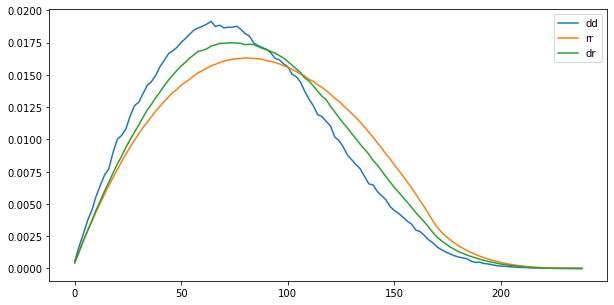

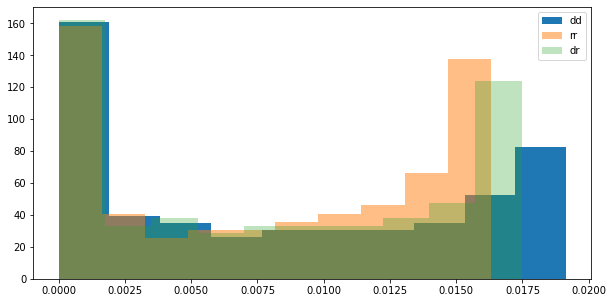

In [11]:
## plot bin and vals for dd, rr, and dr
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.plot(dd_bin,dd_val,label='dd');
plt.plot(rr_bin,rr_val,label='rr');
plt.plot(dr_bin,dr_val,label='dr');
plt.legend();
plt.show()
## plot histogram of dd, rr, and dr
fig, ax = plt.figure(figsize=(10,5)), plt.gca()
plt.hist(dd_val,density=True,alpha=1,label='dd');
plt.hist(rr_val,density=True, alpha=0.5,label='rr');
plt.hist(dr_val,density=True, alpha=0.3,label='dr');
plt.legend();
plt.show(); ## does this look weird?

/tmp/ipykernel_17338/2229321530.py:15: RuntimeWarning: invalid value encountered in double_scalars
  w_b = [dd_i/dr_i -1 for dd_i,dr_i in zip(dd_val,dr_val)]


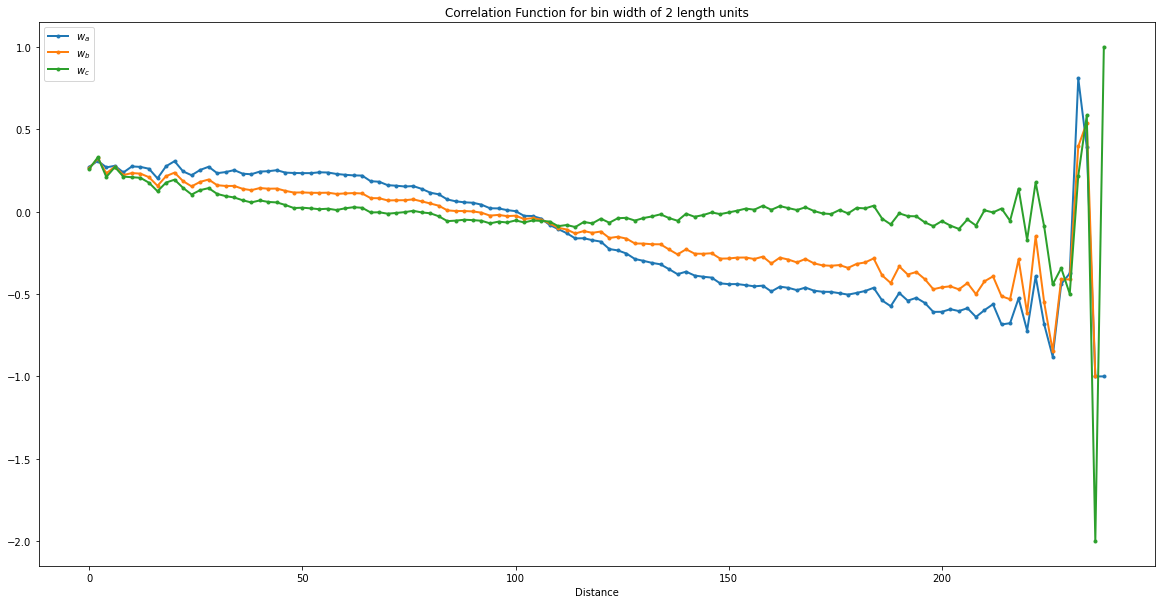

In [12]:
## calculate correlation function
# def get_corr_func(dd,rr,dr,binWidth=binWidth,pkl=False,save=False, timeit=True):
#     start_time = time.time() if timeit else None
#     if pkl and os.path.isfile(pkl):
#         corrFunc = pd.read_pickle(pkl)
#         return corrFunc
#     corrFunc = None
#     if save:
#         pd.to_pickle(corrFunc, save)
#     print("--- %s seconds ---" % (time.time() - start_time)) if timeit else None
#     return corrFunc


w_a = [dd_i/rr_i -1 for dd_i,rr_i in zip(dd_val,rr_val)]
w_b = [dd_i/dr_i -1 for dd_i,dr_i in zip(dd_val,dr_val)]
w_c = [(dd_i - 2*dr_i +rr_i)/(rr_i) for dd_i,dr_i,rr_i in zip(dd_val,dr_val,rr_val)] ## w_c seems to be too big

## plot correlation function (1 instance)
fig, ax = plt.figure(figsize=(20,10)), plt.gca()
plt.plot(dd_bin,w_a,label=r'$w_a$',linestyle='-',linewidth=2, marker='o',markersize=3);
plt.plot(dr_bin,w_b,label=r'$w_b$',linestyle='-',linewidth=2, marker='o',markersize=3,alpha=1);
plt.plot(dr_bin,np.array(w_c),label=r'$w_c$',linestyle='-',linewidth=2, marker='o',markersize=3, alpha=1);
plt.legend();
plt.xlabel('Distance');
plt.title('Correlation Function for bin width of %s length units'%str(binWidth));

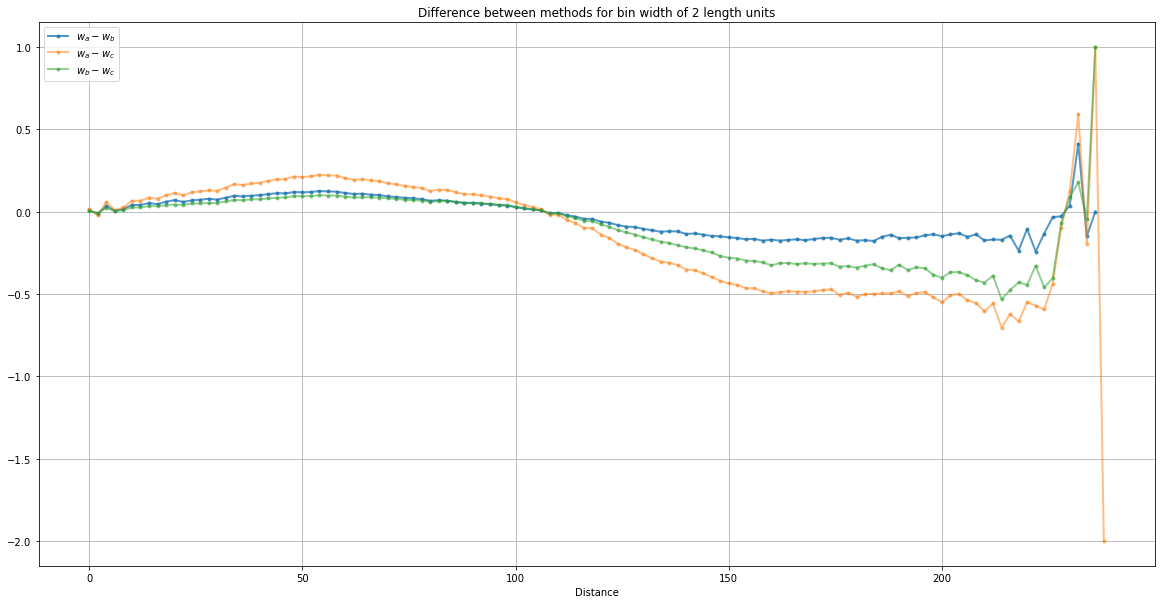

In [13]:
## plot differences between methods 
fig, ax = plt.figure(figsize=(20,10)), plt.gca()
plt.plot(dd_bin,np.array(w_a)-np.array(w_b),label=r'$w_a-w_b$',linestyle='-',linewidth=2, marker='o',markersize=3,alpha=0.75);
plt.plot(dd_bin,np.array(w_a)-np.array(w_c),label=r'$w_a-w_c$',linestyle='-',linewidth=2, marker='o',markersize=3,alpha=0.5);
plt.plot(dd_bin,np.array(w_b)-np.array(w_c),label=r'$w_b-w_c$',linestyle='-',linewidth=2, marker='o',markersize=3,alpha=0.5);
plt.legend();
plt.xlabel('Distance');
plt.title('Difference between methods for bin width of %s length units'%str(binWidth));
plt.grid()
## could probably normalize this somehow to get a better idea of the differences

In [14]:
## run 10-30 times to calculate the rms error of the correlation function for each bin
def get_rms_error(mode=None,n=10,plot=True,save=False,fun=False):
    start_time = time.time()
    randGals = [gen_galaxy_positions(N=10000,timeit=False) for i in range(n)]
    #if mode == 'w_a':
        
    dd = [get_dist('dd',data,data, timeit=False) for i in range(n)] ## I know this is redundant, but this only takes a small amount of time anyway
    rr = [get_dist('rr',r1, r2,timeit=False) for r1,r2 in zip(randGals,randGals)]
    dr = [get_dist('dr',data,r2, timeit=False) for r2 in randGals]

    
    dd_get_bins = [get_bin_averages(d_i, timeit=False) for d_i in dd]
    dd_bin, dd_avg = zip(*dd_get_bins)
    rr_get_bins = [get_bin_averages(r_i, timeit=False) for r_i in rr]
    rr_bin, rr_avg = zip(*rr_get_bins)
    dr_get_bins = [get_bin_averages(d_i, timeit=False) for d_i in dr]
    dr_bin, dr_avg = zip(*dr_get_bins)

    w_a, w_b, w_c = [], [], []
    for dd_i, rr_i, dr_i in zip(dd_avg, rr_avg, dr_avg):
        #print(i)
        w_a.append([dd_j/rr_j -1 for dd_j,rr_j in zip(dd_i,rr_i)])
        w_b.append([dd_j/dr_j -1 for dd_j,dr_j in zip(dd_i,dr_i)])
        w_c.append([(dd_j - 2*dr_j +rr_j)/(rr_j) for dd_j,dr_j,rr_j in zip(dd_i,dr_i,rr_i)])
    w_a = np.array(w_a)
    w_b = np.array(w_b)
    w_c = np.array(w_c)
    ## actually, you want to average the value of each bin when calculating <
    #print(w_a) 
    ## could do this across axis 0 instead I think
    # print(w_a.shape)
    # print(w_b.shape)
    # print(w_c.shape)
    avg_w_a = np.mean(w_a,axis=0);
    avg_w_b = np.mean(w_b,axis=0);
    avg_w_c = np.mean(w_c,axis=0);

    rms_w_a = np.sqrt(np.mean((w_a)**2,axis=0));
    rms_w_b = np.sqrt(np.mean((w_b)**2,axis=0));
    rms_w_c = np.sqrt(np.mean((w_c)**2,axis=0));

    # rms_w_a_unzip = np.array([[item[i] for item in w_a] for i in range(len(w_a[0]))]) ## workaround for unzip since that was being odd
    # rms_w_a = [np.sqrt(np.mean(item**2)) for item in rms_w_a_unzip]
    # rms_w_b_unzip = np.array([[item[i] for item in w_b] for i in range(len(w_b[0]))]) 
    # rms_w_b = [np.sqrt(np.mean(item**2)) for item in rms_w_b_unzip]
    # rms_w_c_unzip = np.array([[item[i] for item in w_c] for i in range(len(w_c[0]))])
    # rms_w_c = [np.sqrt(np.mean(item**2)) for item in rms_w_c_unzip]

    if plot: ## just going to plot the first sample with the rms error for ease of code
        fig, ax = plt.figure(figsize=(10,7.5)), plt.gca()
        plt.xlim(right=227)
        plt.ylim((-1,1))
        plt.errorbar(dd_bin[0][:-2],avg_w_a[:-2], yerr=rms_w_a[:-2], label=r'$w_a$',linestyle='-',linewidth=2, marker='o',markersize=5,alpha=0.5);
        plt.errorbar(dr_bin[0][:-2],avg_w_b[:-2], yerr=rms_w_b[:-2], label=r'$w_b$',linestyle='-',linewidth=2, marker='o',markersize=5,alpha=0.5);
        plt.errorbar(dr_bin[0][:-2],avg_w_c[:-2], yerr=rms_w_c[:-2], label=r'$w_c$',linestyle='-',linewidth=2, marker='o',markersize=5, alpha=0.5);
        
        plt.legend();
        plt.xlabel('Distance');
        plt.title('Correlation Function for bin width \n of {binWidth} length units and {n} samples '.format(binWidth=str(binWidth),n=str(n)));
        plt.grid();
        if save:
            plt.savefig('correlation_function.png')
        plt.show()


(2, 120)
(2, 120)
(2, 120)


/tmp/ipykernel_17338/2316646862.py:23: RuntimeWarning: invalid value encountered in double_scalars
  w_b.append([dd_j/dr_j -1 for dd_j,dr_j in zip(dd_i,dr_i)])


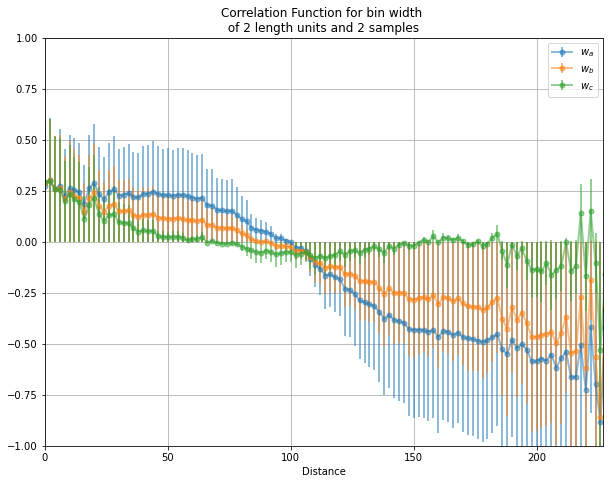

In [15]:
get_rms_error(n=2, save=True)
## Not sure why rms is higher than expected since the expression for rms is correct

In [16]:
print("--- %s seconds ---" % (time.time() - bigstart))

--- 43.702908992767334 seconds ---
